### Introdução

Abaixo eu deixo um esquema simples de um robo com duas rodas que pode percorrer a plantação, e o esquematico do ESP32Cam.

Nesse colab vou dar uma breve codigo para usar o ESP32Cam.



> referencias: https://www.youtube.com/watch?v=12pnrK3J39A



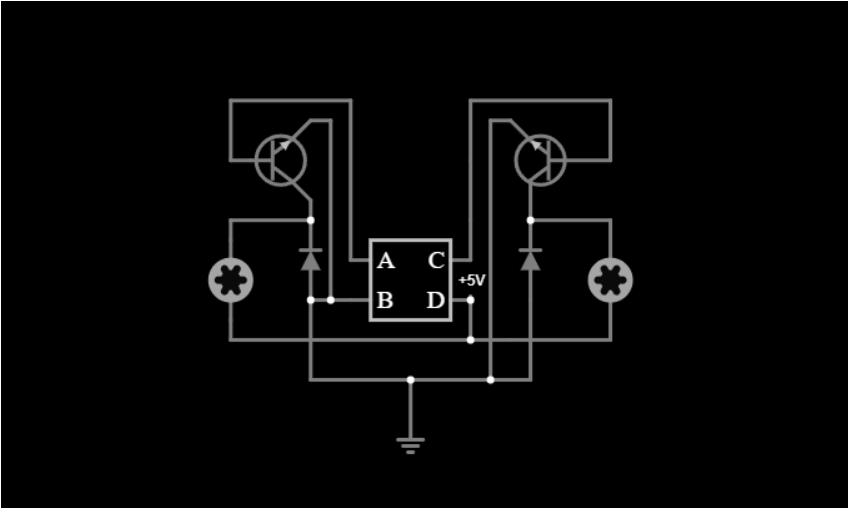

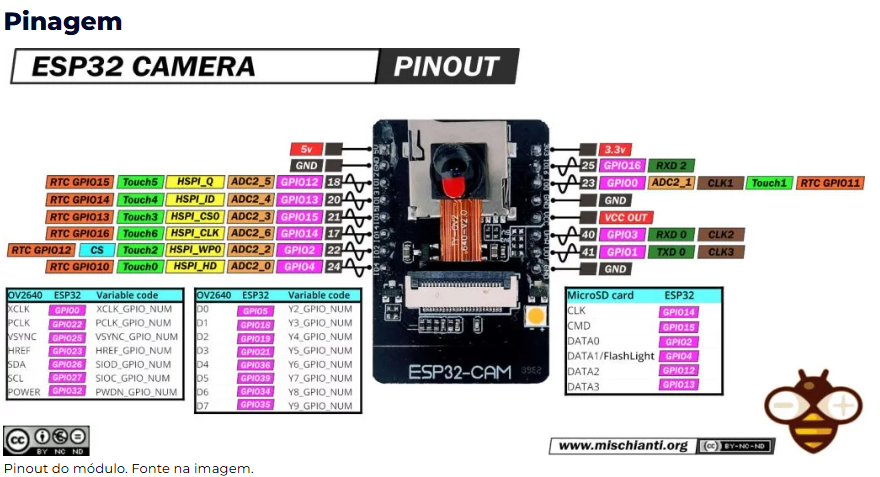

In [ ]:
#include "esp_camera.h"
#include <WiFi.h>
#include "esp_timer.h"
#include "img_converters.h"
#include "Arduino.h"
#include "fb_gfx.h"
#include "soc/soc.h"
#include "soc/rtc_cntl_reg.h"
#include "esp_http_server.h"

const char* ssid = "********";
const char* password = "*******";

#define PWDN_GPIO_NUM     32
#define RESET_GPIO_NUM    -1
#define XCLK_GPIO_NUM      0
#define SIOD_GPIO_NUM     26
#define SIOC_GPIO_NUM     27
#define Y9_GPIO_NUM       35
#define Y8_GPIO_NUM       34
#define Y7_GPIO_NUM       39
#define Y6_GPIO_NUM       36
#define Y5_GPIO_NUM       21
#define Y4_GPIO_NUM       19
#define Y3_GPIO_NUM       18
#define Y2_GPIO_NUM        5
#define VSYNC_GPIO_NUM    25
#define HREF_GPIO_NUM     23
#define PCLK_GPIO_NUM     22

#define PART_BOUNDARY "123456789000000000000987654321"
static const char* _STREAM_CONTENT_TYPE = "multipart/x-mixed-replace;boundary=" PART_BOUNDARY;
static const char* _STREAM_BOUNDARY = "\r\n--" PART_BOUNDARY "\r\n";
static const char* _STREAM_PART = "Content-Type: image/jpeg\r\nContent-Length: %u\r\n\r\n";

httpd_handle_t stream_httpd = NULL;

static esp_err_t stream_handler(httpd_req_t *req){
  camera_fb_t * fb = NULL;
  esp_err_t res = ESP_OK;
  size_t _jpg_buf_len = 0;
  uint8_t * _jpg_buf = NULL;
  char * part_buf[64];

  res = httpd_resp_set_type(req, _STREAM_CONTENT_TYPE);
  if(res != ESP_OK){
    return res;
  }

  while(true){
    fb = esp_camera_fb_get();
    if (!fb) {
      Serial.println("Camera capture failed");
      res = ESP_FAIL;
    } else {
      if(fb->width > 400){
        if(fb->format != PIXFORMAT_JPEG){
          bool jpeg_converted = frame2jpg(fb, 80, &_jpg_buf, &_jpg_buf_len);
          esp_camera_fb_return(fb);
          fb = NULL;
          if(!jpeg_converted){
            Serial.println("JPEG compression failed");
            res = ESP_FAIL;
          }
        } else {
          _jpg_buf_len = fb->len;
          _jpg_buf = fb->buf;
        }
      }
    }
    if(res == ESP_OK){
      size_t hlen = snprintf((char *)part_buf, 64, _STREAM_PART, _jpg_buf_len);
      res = httpd_resp_send_chunk(req, (const char *)part_buf, hlen);
    }
    if(res == ESP_OK){
      res = httpd_resp_send_chunk(req, (const char *)_jpg_buf, _jpg_buf_len);
    }
    if(res == ESP_OK){
      res = httpd_resp_send_chunk(req, _STREAM_BOUNDARY, strlen(_STREAM_BOUNDARY));
    }
    if(fb){
      esp_camera_fb_return(fb);
      fb = NULL;
      _jpg_buf = NULL;
    } else if(_jpg_buf){
      free(_jpg_buf);
      _jpg_buf = NULL;
    }
    if(res != ESP_OK){
      break;
    }
  }
  return res;
}

void startCameraServer(){
  httpd_config_t config = HTTPD_DEFAULT_CONFIG();
  config.server_port = 80;

  httpd_uri_t index_uri = {
    .uri       = "/",
    .method    = HTTP_GET,
    .handler   = stream_handler,
    .user_ctx  = NULL
  };

  if (httpd_start(&stream_httpd, &config) == ESP_OK) {
    httpd_register_uri_handler(stream_httpd, &index_uri);
  }
}

void setup() {
  WRITE_PERI_REG(RTC_CNTL_BROWN_OUT_REG, 0); //desativa o detector de brownout

  Serial.begin(115200);
  Serial.setDebugOutput(false);

  camera_config_t config;
  config.ledc_channel = LEDC_CHANNEL_0;
  config.ledc_timer = LEDC_TIMER_0;
  config.pin_d0 = Y2_GPIO_NUM;
  config.pin_d1 = Y3_GPIO_NUM;
  config.pin_d2 = Y4_GPIO_NUM;
  config.pin_d3 = Y5_GPIO_NUM;
  config.pin_d4 = Y6_GPIO_NUM;
  config.pin_d5 = Y7_GPIO_NUM;
  config.pin_d6 = Y8_GPIO_NUM;
  config.pin_d7 = Y9_GPIO_NUM;
  config.pin_xclk = XCLK_GPIO_NUM;
  config.pin_pclk = PCLK_GPIO_NUM;
  config.pin_vsync = VSYNC_GPIO_NUM;
  config.pin_href = HREF_GPIO_NUM;
  config.pin_sscb_sda = SIOD_GPIO_NUM;
  config.pin_sscb_scl = SIOC_GPIO_NUM;
  config.pin_pwdn = PWDN_GPIO_NUM;
  config.pin_reset = RESET_GPIO_NUM;
  config.xclk_freq_hz = 20000000;
  config.pixel_format = PIXFORMAT_JPEG;

  config.frame_size = FRAMESIZE_UXGA;
  config.jpeg_quality = 40;
  config.fb_count = 2;


  // Inicia a câmera
  esp_err_t err = esp_camera_init(&config);
  if (err != ESP_OK) {
    Serial.printf("Camera init failed with error 0x%x", err);
    return;
  }
  // Conecta o WiFi
  WiFi.begin(ssid, password);
  while (WiFi.status() != WL_CONNECTED) {
    delay(500);
    Serial.print(".");
  }
  Serial.println("");
  Serial.println("WiFi connected");

  Serial.print("Camera Stream Ready! Go to: http://");
  Serial.print(WiFi.localIP());

  // Start streaming web server
  startCameraServer();
}

void loop() {
  delay(1);  //nenhuma ação relevante é realizada no loop
}